# Convert target distances JSON to a matrix

The matrix will ultimately be used by the Python earth mover's distance (EMD) module as the pairwise distance matrix for viruses.

Initial attempts to use `pyemd` failed, so I switched to the [OpenCV implementation](https://docs.opencv.org/3.4.3/d6/dc7/group__imgproc__hist.html#ga902b8e60cc7075c8947345489221e0e0) that is helpfully described in [this blog post](https://samvankooten.net/2018/09/25/earth-movers-distance-in-python/).

In [139]:
from augur.frequency_estimators import TreeKdeFrequencies
import cv2
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

In [58]:
# Load frequencies for two timepoints.
freq_a_path = "../results/builds/h3n2/1_viruses_per_month/sample_0/2000-10-01--2015-10-01/timepoints/2009-10-01/segments/ha/frequencies.json"
with open(freq_a_path, "r") as fh:
    freq_a_json = json.load(fh)

In [59]:
freq_b_path = "../results/builds/h3n2/1_viruses_per_month/sample_0/2000-10-01--2015-10-01/timepoints/2010-10-01/segments/ha/frequencies.json"
with open(freq_b_path, "r") as fh:
    freq_b_json = json.load(fh)

In [60]:
freq_a = TreeKdeFrequencies.from_json(freq_a_json)

In [61]:
freq_b = TreeKdeFrequencies.from_json(freq_b_json)

In [128]:
samples_a = []
frequencies_a = []
for sample, frequencies in freq_a.frequencies.items():
    if sample.startswith("A/") and frequencies[-1] > 0:
        samples_a.append(sample)
        frequencies_a.append(frequencies[-1])

In [127]:
samples_b = []
frequencies_b = []
for sample, frequencies in freq_b.frequencies.items():
    if sample.startswith("A/") and frequencies[-1] > 0:
        samples_b.append(sample)
        frequencies_b.append(frequencies[-1])

In [129]:
frequencies_a = np.array(frequencies_a)
frequencies_b = np.array(frequencies_b)

In [74]:
len(samples_a)

74

In [75]:
len(samples_b)

63

In [76]:
samples_a[:10]

['A/Aragon/RR-3438/2008',
 'A/Bangladesh/2363/2009',
 'A/Bangladesh/483/2009',
 'A/BeijingXicheng/1108/2009',
 'A/Bhutan/154/2009',
 'A/Brazil/1814/2009',
 'A/California/VRDL208/2009',
 'A/California/VRDL330/2009',
 'A/Colombia/227/2009',
 'A/Colombia/7158/2009']

In [77]:
# Load pairwise distances.
df = pd.read_csv(
    "../results/builds/h3n2/1_viruses_per_month/sample_0/2000-10-01--2015-10-01/target_distances.tsv",
    sep="\t"
)

In [78]:
df.head()

,distance,other_sample,sample
0,0,A/Auckland/603/2001,A/Auckland/603/2001
1,3,A/Auckland/611/2002,A/Auckland/603/2001
2,2,A/Auckland/614/2002,A/Auckland/603/2001
3,2,A/Auckland/615/2002,A/Auckland/603/2001
4,19,A/Brisbane/342/2003,A/Auckland/603/2001


In [79]:
# Find all distinct samples with distances.
samples = np.union1d(df["sample"].unique(), df["other_sample"].unique())

In [80]:
samples

array(['A/Acre/15093/2010', 'A/Acre/26954/2010', 'A/Adana/111/2014', ...,
       'A/Zambia/13/109/2013', 'A/Zambia/13/127/2013',
       'A/Zambia/2-00106/2015'], dtype=object)

In [81]:
# Map sample name to index in distance array.
sample_to_index = dict([(sample, i) for i, sample in enumerate(samples)])

In [82]:
list(sample_to_index.items())[:10]

[('A/Acre/15093/2010', 0),
 ('A/Acre/26954/2010', 1),
 ('A/Adana/111/2014', 2),
 ('A/Adjame/GR765/2011', 3),
 ('A/Afghanistan/2950/2009', 4),
 ('A/Aichi/1/2015', 5),
 ('A/Aichi/116/2013', 6),
 ('A/Aichi/118/2013', 7),
 ('A/Akita/14/2012', 8),
 ('A/Alabama/5/2010', 9)]

In [83]:
# Create a pairwise distance matrix for samples.
distances = np.zeros((samples.shape[0], samples.shape[0]), dtype=int)

In [84]:
distances.shape

(1032, 1032)

In [85]:
distances[:10, :10]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [86]:
df.head()

,distance,other_sample,sample
0,0,A/Auckland/603/2001,A/Auckland/603/2001
1,3,A/Auckland/611/2002,A/Auckland/603/2001
2,2,A/Auckland/614/2002,A/Auckland/603/2001
3,2,A/Auckland/615/2002,A/Auckland/603/2001
4,19,A/Brisbane/342/2003,A/Auckland/603/2001


In [87]:
# Populate the pairwise distance matrix.
for distance, sample_b, sample_a in df.values:
    sample_a_index = sample_to_index[sample_a]
    sample_b_index = sample_to_index[sample_b]
    distances[sample_a_index, sample_b_index] = distance
    distances[sample_b_index, sample_a_index] = distance

In [88]:
record["sample"]

'A/NewYork/42/2003'

In [89]:
record["other_sample"]

'A/Japan/7542/2007'

In [90]:
record["distance"]

16

In [113]:
distances[:15, :15]

array([[ 0,  2, 16, 10,  9, 22, 18, 17, 12, 14, 15, 21, 20, 23, 23],
       [ 2,  0, 16, 10,  7, 22, 18, 17, 12, 12, 15, 21, 20, 23, 23],
       [16, 16,  0, 11, 11,  7,  6,  5,  8, 16,  1,  6,  5,  8,  8],
       [10, 10, 11,  0,  6, 17, 13, 12,  5, 11, 10, 16, 15, 18, 18],
       [ 9,  7, 11,  6,  0, 18, 13, 12,  7,  7, 10, 17, 16, 19, 19],
       [22, 22,  7, 17, 18,  0, 13, 12, 13, 21,  8,  3,  2,  5,  5],
       [18, 18,  6, 13, 13, 13,  0,  3, 10, 18,  5, 12, 11, 14, 13],
       [17, 17,  5, 12, 12, 12,  3,  0,  9, 17,  4, 11, 10, 13, 13],
       [12, 12,  8,  5,  7, 13, 10,  9,  0, 10,  7, 12, 11, 14, 14],
       [14, 12, 16, 11,  7, 21, 18, 17, 10,  0, 15, 20, 19, 22, 20],
       [15, 15,  1, 10, 10,  8,  5,  4,  7, 15,  0,  7,  6,  9,  9],
       [21, 21,  6, 16, 17,  3, 12, 11, 12, 20,  7,  0,  1,  4,  2],
       [20, 20,  5, 15, 16,  2, 11, 10, 11, 19,  6,  1,  0,  3,  3],
       [23, 23,  8, 18, 19,  5, 14, 13, 14, 22,  9,  4,  3,  0,  6],
       [23, 23,  8, 18, 19,  5, 13

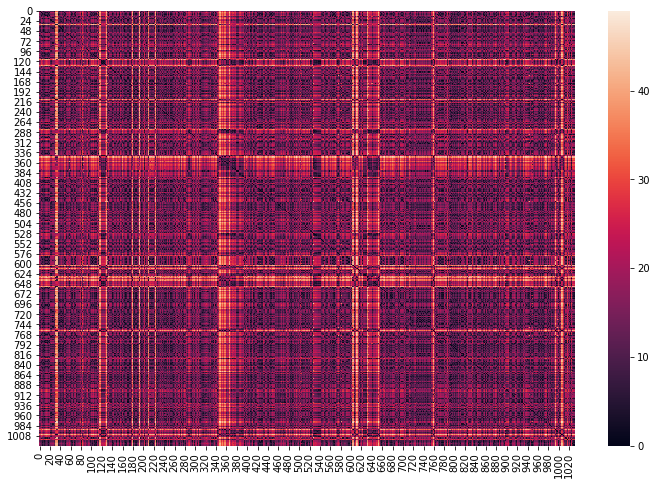

In [92]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
sns.heatmap(distances, ax=ax)

In [124]:
index_a = np.array([sample_to_index[sample] for sample in samples_a])
index_b = np.array([sample_to_index[sample] for sample in samples_b])

In [125]:
distances[np.ix_(index_a, index_b)].shape

(74, 63)

In [126]:
distances[np.ix_(index_a, index_b)]

array([[10,  8, 10, ...,  9,  6,  9],
       [ 9,  7,  7, ...,  8,  3,  6],
       [ 8,  6,  6, ...,  7,  2,  5],
       ...,
       [10,  8, 10, ...,  9,  6,  9],
       [10,  8,  8, ...,  9,  4,  7],
       [ 7,  5, 11, ...,  6,  7, 10]])

In [132]:
frequencies_a.shape

(74,)

In [135]:
frequencies_a.dtype

dtype('float64')

In [133]:
frequencies_b.shape

(63,)

In [165]:
distances[np.ix_(index_a, index_b)]

array([[10,  8, 10, ...,  9,  6,  9],
       [ 9,  7,  7, ...,  8,  3,  6],
       [ 8,  6,  6, ...,  7,  2,  5],
       ...,
       [10,  8, 10, ...,  9,  6,  9],
       [10,  8,  8, ...,  9,  4,  7],
       [ 7,  5, 11, ...,  6,  7, 10]])

In [145]:
frequencies_a.astype(np.float32)

array([2.8000e-05, 2.0900e-02, 2.0003e-02, 1.1760e-03, 2.3797e-02,
       2.1644e-02, 1.9600e-02, 2.1364e-02, 2.0003e-02, 2.3609e-02,
       2.3655e-02, 2.2245e-02, 1.2815e-02, 1.6618e-02, 1.6270e-02,
       2.2135e-02, 6.1300e-04, 2.3832e-02, 9.3940e-03, 1.2815e-02,
       1.5914e-02, 2.3878e-02, 2.3724e-02, 7.4000e-05, 2.3312e-02,
       1.5626e-02, 2.3873e-02, 8.2000e-05, 1.0980e-03, 2.3812e-02,
       3.8200e-03, 1.1874e-02, 2.2654e-02, 3.0000e-06, 6.0380e-03,
       2.3812e-02, 2.0000e-06, 1.4360e-02, 1.5900e-04, 1.0000e-06,
       1.0000e-06, 1.2580e-03, 6.0000e-05, 2.3094e-02, 3.0000e-06,
       2.0941e-02, 2.3030e-02, 2.3864e-02, 4.1300e-04, 1.5820e-03,
       1.9652e-02, 2.3573e-02, 6.0000e-05, 1.3747e-02, 2.3078e-02,
       1.3747e-02, 1.2580e-03, 2.2874e-02, 1.4131e-02, 1.3438e-02,
       2.2374e-02, 1.9670e-03, 2.0051e-02, 2.2800e-04, 2.0195e-02,
       2.2892e-02, 4.6350e-03, 7.1400e-04, 2.3433e-02, 1.4000e-05,
       2.3433e-02, 1.1247e-02, 1.8779e-02, 2.3602e-02], dtype=

In [159]:
emd, _, flow = cv2.EMD(
    frequencies_a.astype(np.float32),
    frequencies_b.astype(np.float32),
    cv2.DIST_USER,
    cost=distances[np.ix_(index_a, index_b)].astype(np.float32)
)

In [160]:
emd

6.563948154449463

In [162]:
flow.shape

(74, 63)

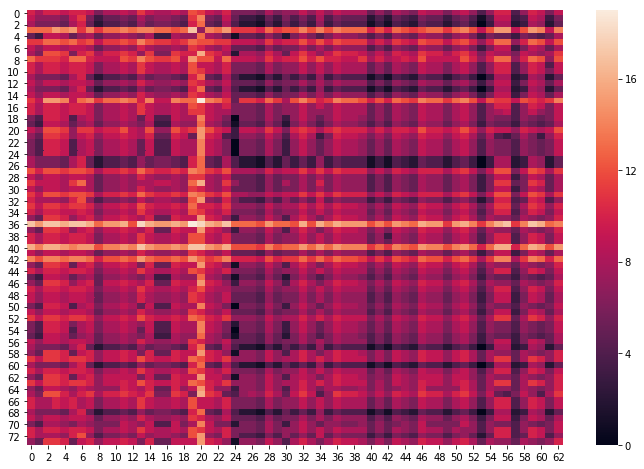

In [163]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
sns.heatmap(distances[np.ix_(index_a, index_b)], ax=ax)

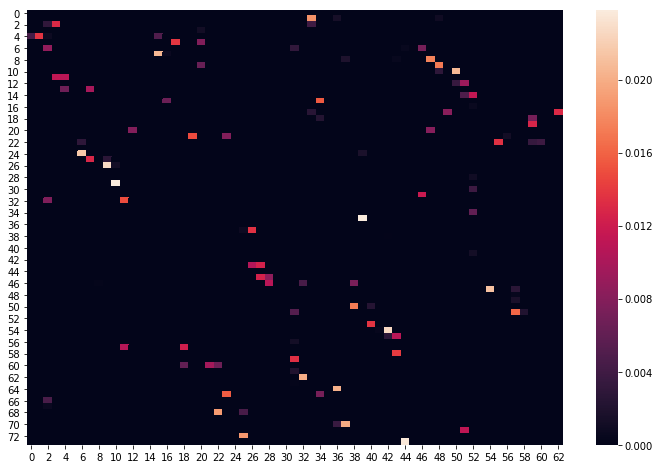

In [164]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
sns.heatmap(flow, ax=ax)